In [2]:
history = {}

In [4]:
%run "~/persistence/sepkoskiMakerV6.ipynb"
mpl.rcParams['figure.dpi']= 300

In [5]:
clade_of_interest = "Metazoa"
clade_resolution = "genus"

# Options are terr, marine
env_type = "marine"
min_occurrences = 1

#["motility","life_habit","vision","diet","reproduction","ontogeny"]
#ecotype_restrictions = {"diet":"carnivore"}
ecotype_restrictions = None

t_0 = 550

bins = 50
bin_size = t_0 / bins

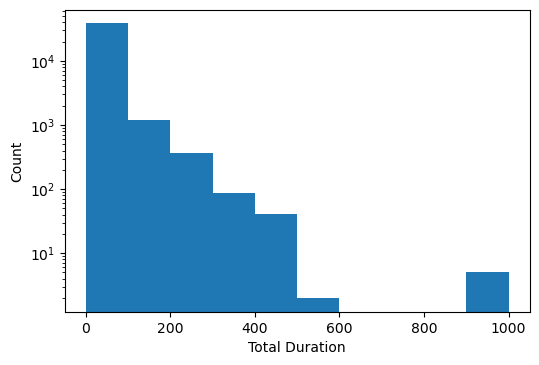

In [8]:
tag = ",".join([clade_of_interest, clade_resolution, str(env_type), str(min_occurrences)])
if tag in history:
    subcladeDict = history[tag]
    #richnessNums = get_richness(durationMatrixMetazoa)
    plt.hist([max(subcladeDict[subclade]) - min(subcladeDict[subclade]) for subclade in subcladeDict])
    plt.yscale('log', nonpositive='clip')
    plt.xlabel("Total Duration")
    plt.ylabel("Count")
else:
    subcladeDict = getSubcladeOccurences(clade_of_interest, resolution=clade_resolution, 
                                         environment_only=env_type, plot=True)[clade_resolution]
    history[tag] = subcladeDict

Text(0.5, 1.0, 'Metazoa, marine')

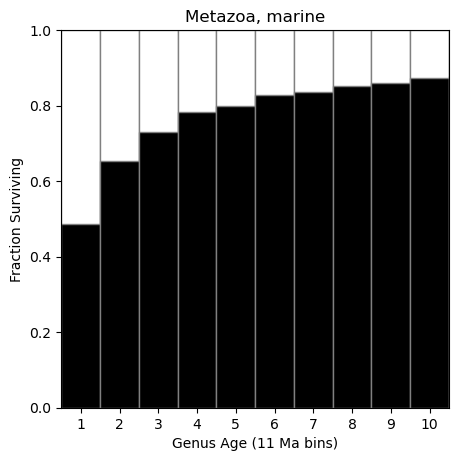

In [9]:
permissiveDurationMatrix = getDurationMatrix(subcladeDict, n_bins=50, t_0=t_0, max_duration=275, min_occurrences=1)
overallSurvival, _ = getSurvivalsByAge(permissiveDurationMatrix, max_age=40)
overallSurvival = list(overallSurvival.values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("%s Age (11 Ma bins)"%(clade_resolution.title()))
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 40 + 1), [1]*40,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 40 + 1), overallSurvival, color='black', edgecolor='gray', width=1)
ax.set_title(clade_of_interest+", "+env_type)

In [10]:
ecospace_dict = getSubcladeEcospace(clade_of_interest, environment_only=env_type, resolution=clade_resolution)
if ecotype_restrictions:
    for term in ecotype_restrictions:
        subcladeDict = {x:subcladeDict[x] for x in subcladeDict if x in ecospace_dict and ecotype_restrictions[term] in ecospace_dict[x][term]}

In [11]:
trait_of_interest = "motility"
min_trait_occ = 100

def getPossibleTypes(ecospace_dict, heading, verbose=False, min_numbers=1000):
    words = []
    for x in [ecospace_dict[x][heading] for x in ecospace_dict]: words += x
    unq_words = list(set(words))
    unq_words = sorted(list(set(unq_words)), key=lambda x: -words.count(x))
    #print(unq_words)
    if verbose:
        for word in unq_words:
            print(word, words.count(word))
    return [x for x in unq_words if words.count(x) > min_numbers]

categories = list(ecospace_dict[list(ecospace_dict.keys())[0]].keys())
print(categories)

words = getPossibleTypes(ecospace_dict, trait_of_interest, verbose=True)

['motility', 'life_habit', 'vision', 'diet', 'reproduction', 'ontogeny', 'lithology1', 'lithification1', 'composition', 'reinforcement']
actively mobile 18731
stationary 11393
attached 7895
fast-moving 5381
facultatively mobile 2926
slow-moving 1145
epibiont 432
passively mobile 293


In [12]:
subcladeDictsByTraits = {}
for cat in [trait_of_interest]:
    words = getPossibleTypes(ecospace_dict, cat, min_numbers=min_trait_occ)
    for word in words:
        wordDict =  {x:subcladeDict[x] for x in subcladeDict if x in ecospace_dict and word in ecospace_dict[x][cat]}
        subcladeDictsByTraits["%s,%s"%(cat,word)] = wordDict
        
subcladeStartEndsByTraits = {x:getSubcladeAgeRanges(subcladeDictsByTraits[x], min_occurence_threshold=1) for x in subcladeDictsByTraits}

(0.0, 3507.0)

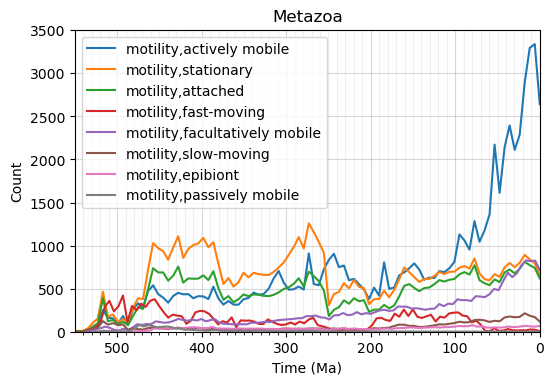

In [13]:
plotSepkoskiBins(subcladeStartEndsByTraits, t_0=t_0, n_bins=100)
plt.title(clade_of_interest)
plt.xlim(t_0,0)
plt.ylim(0,None)
#plt.ylim(0,250)

In [14]:
#Observe turnover in modes of life
turnover_resolution = "phylum"

traitByPhylum = {}
cohorts = getSupercladeCohorts(clade_of_interest, superclade_resolution=turnover_resolution, 
                               subclade_resoltion=clade_resolution, environment_only=env_type)


Local save of requested search found.



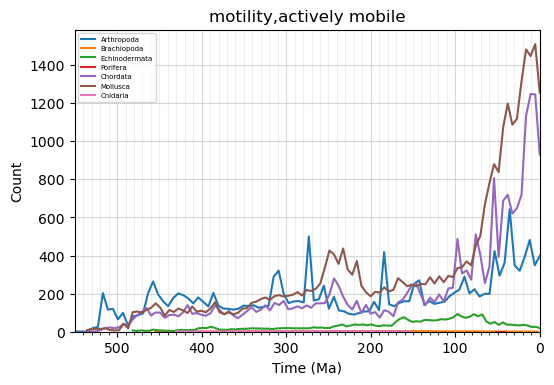

In [15]:
specific_trait = "actively mobile"

for phylum in cohorts:
    if len(cohorts[phylum]) < 1000:
        continue
    wordDict =  {x:subcladeDict[x] for x in subcladeDict if x in cohorts[phylum] and specific_trait in ecospace_dict[x][trait_of_interest]}
    if wordDict != {}:
        traitByPhylum[phylum] = wordDict
startEndsByPhylum = {x:getSubcladeAgeRanges(traitByPhylum[x], min_occurence_threshold=0) for x in traitByPhylum}
plotSepkoskiBins(startEndsByPhylum, t_0=t_0, n_bins=100)
plt.title(trait_of_interest+","+specific_trait)
plt.xlim(t_0,0)
plt.ylim(0,None)
plt.legend(fontsize=5)

18730 11392


(0.0, 1.0)

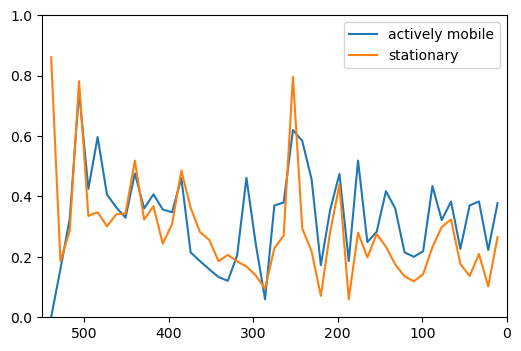

In [19]:
# Compare extinction rates between two categories
cat1, cat2 = "actively mobile", "stationary"

subcladeDictMotile = {x:subcladeDict[x] for x in subcladeDict if x in ecospace_dict and cat1 in ecospace_dict[x][trait_of_interest]}
subcladeDictStationary = {x:subcladeDict[x] for x in subcladeDict if x in ecospace_dict and cat2 in ecospace_dict[x][trait_of_interest]} #and x not in subcladeDictMotile}

print(len(subcladeDictMotile), len(subcladeDictStationary))

bins_to_time_ext = [(t_0 - (bin_size * x)) - (1 * bin_size) for x in range(bins)]

durationMatrixMot, _ = getDurationMatrix(subcladeDictMotile, n_bins=bins, t_0=t_0, 
                                             max_duration=1000, min_occurrences=min_occurrences,
                                             min_unique=False, return_labels=True)

durationMatrixStat, _ = getDurationMatrix(subcladeDictStationary, n_bins=bins, t_0=t_0, 
                                             max_duration=1000, min_occurrences=min_occurrences,
                                             min_unique=False, return_labels=True)

extinctionRatesMot = get_extinction_rate(durationMatrixMot)
extinctionRatesStat = get_extinction_rate(durationMatrixStat)

plt.plot(bins_to_time_ext, extinctionRatesMot, label=cat1)
plt.plot(bins_to_time_ext, extinctionRatesStat, label=cat2)
plt.legend()
plt.xlim(t_0,0)
plt.ylim(0,1)

Text(0.5, 0, 'Time (Ma)')

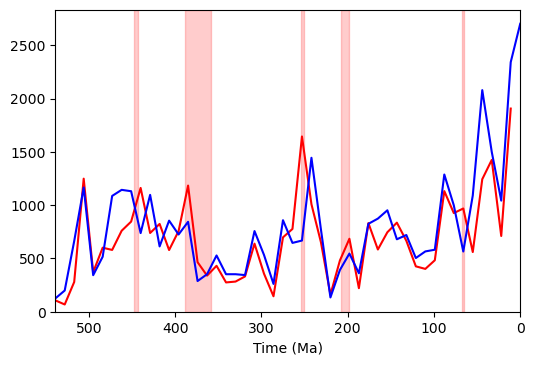

In [21]:
durationMatrixMetazoa, _ = getDurationMatrix(subcladeDict, n_bins=bins, t_0=t_0, 
                                             max_duration=1000, min_occurrences=min_occurrences,
                                             min_unique=False, return_labels=True)
                                             #occurrence_processor=occurrence_bootstrapper)

extinctionRates = get_extinction_rate(durationMatrixMetazoa)
extinctionNums = get_extinction_rate(durationMatrixMetazoa, proportions=False)
speciationNums = get_speciation_rate(durationMatrixMetazoa)

bins_to_time_ext = [(t_0 - (bin_size * x)) - (1 * bin_size) for x in range(bins)]
bins_to_time_spec = [(t_0 - (bin_size * x)) - (1 * bin_size) for x in range(bins)]

fig, ax = plt.subplots()

ax.plot(bins_to_time_ext, extinctionNums, color="red")
ax.plot(bins_to_time_spec, speciationNums, color="blue")
ax.axvspan(448, 443, alpha=0.2, color='red')
ax.axvspan(389, 359, alpha=0.2, color='red')
ax.axvspan(254, 251, alpha=0.2, color='red')
ax.axvspan(208, 199, alpha=0.2, color='red')
ax.axvspan(68, 65, alpha=0.2, color='red')
ax.set_xlim(t_0-bin_size,0)
ax.set_ylim(0, None)
ax.set_xlabel("Time (Ma)")
#ax.set_ylabel("Time (Ma)")

Mean occurrences: 24.02
Median occurrences: 4


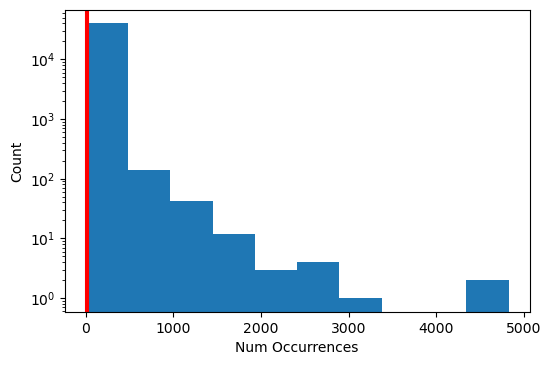

In [22]:
mean_occurrences = np.mean([len(subcladeDict[x]) for x in subcladeDict])
mdn_occurrences = np.median([len(subcladeDict[x]) for x in subcladeDict])

plt.hist([len(subcladeDict[x]) for x in subcladeDict])
plt.yscale('log', nonpositive='clip')
bot, height = plt.gca().get_ylim()
plt.vlines([mean_occurrences, mdn_occurrences], 0, height, color="red")
plt.ylim(bot, height)
plt.xlabel("Num Occurrences")
plt.ylabel("Count")

print("Mean occurrences:", round(mean_occurrences,2))
print("Median occurrences:", int(mdn_occurrences))


In [24]:
taxDicts = {}
superclades = ["phylum","class","order","family"]

for superclade in superclades:
    taxDicts[superclade] = getTaxonomyDict(clade_resolution, superclade, 
                                           subset=clade_of_interest+"_"+env_type, verbose=False)

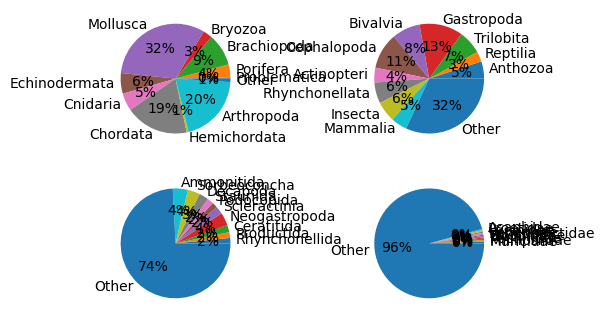

In [26]:
fig,ax = plt.subplots(2,2)
superclades = ["phylum","class","order","family"]

count = 0
for superclade in superclades:
    phyla = [taxDicts[superclade][clade] for clade in subcladeDict if clade in taxDicts[superclade] and len(subcladeDict[clade])>0]
    counts = [phyla.count(x) for x in set(phyla)]
    cutoff = -1
    while(len(counts) > 10):
        cutoff += 1
        counts =  [x for x in counts if x > cutoff]
    counts += [len(phyla) - sum(counts)]
    phyla_labels = [x for x in set(phyla) if phyla.count(x) > cutoff] + ["Other"]
    b = ax[count//2,count%2].pie(counts, labels=phyla_labels, autopct='%1.0f%%')
    count+=1

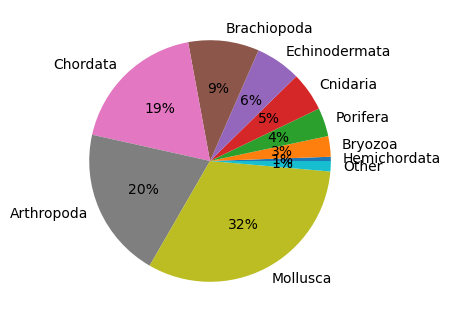

In [27]:
pie_res = "phylum"

fig, ax = plt.subplots()
phyla = [taxDicts[pie_res][clade] for clade in subcladeDict if clade in taxDicts[pie_res] and len(subcladeDict[clade])>0]
counts = [phyla.count(x) for x in set(phyla)]
cutoff = -1
while(len(counts)) > 9:
    cutoff += 1
    counts =  [x for x in counts if x > cutoff]
phyla_labels = [x for x in set(phyla) if phyla.count(x) > cutoff]
phyla_labels = sorted(phyla_labels, key=lambda x:counts[phyla_labels.index(x)])
counts = sorted(counts)

phyla_labels += ["Other"]
counts += [len(phyla) - sum(counts)]

b = ax.pie(counts, labels=phyla_labels, autopct='%1.0f%%')

Local save of requested search found.

12795 unique subclades (['genus']) found
10593 subclades with multiple occurences
8826 subclades with multiple unique occurences
7787 subclades with at least 5 occurences
Local save of requested search found.

8098 unique subclades (['genus']) found
5198 subclades with multiple occurences
3558 subclades with multiple unique occurences
3027 subclades with at least 5 occurences
Local save of requested search found.

7458 unique subclades (['genus']) found
4315 subclades with multiple occurences
3277 subclades with multiple unique occurences
2193 subclades with at least 5 occurences
Local save of requested search found.

3795 unique subclades (['genus']) found
3245 subclades with multiple occurences
2760 subclades with multiple unique occurences
2513 subclades with at least 5 occurences


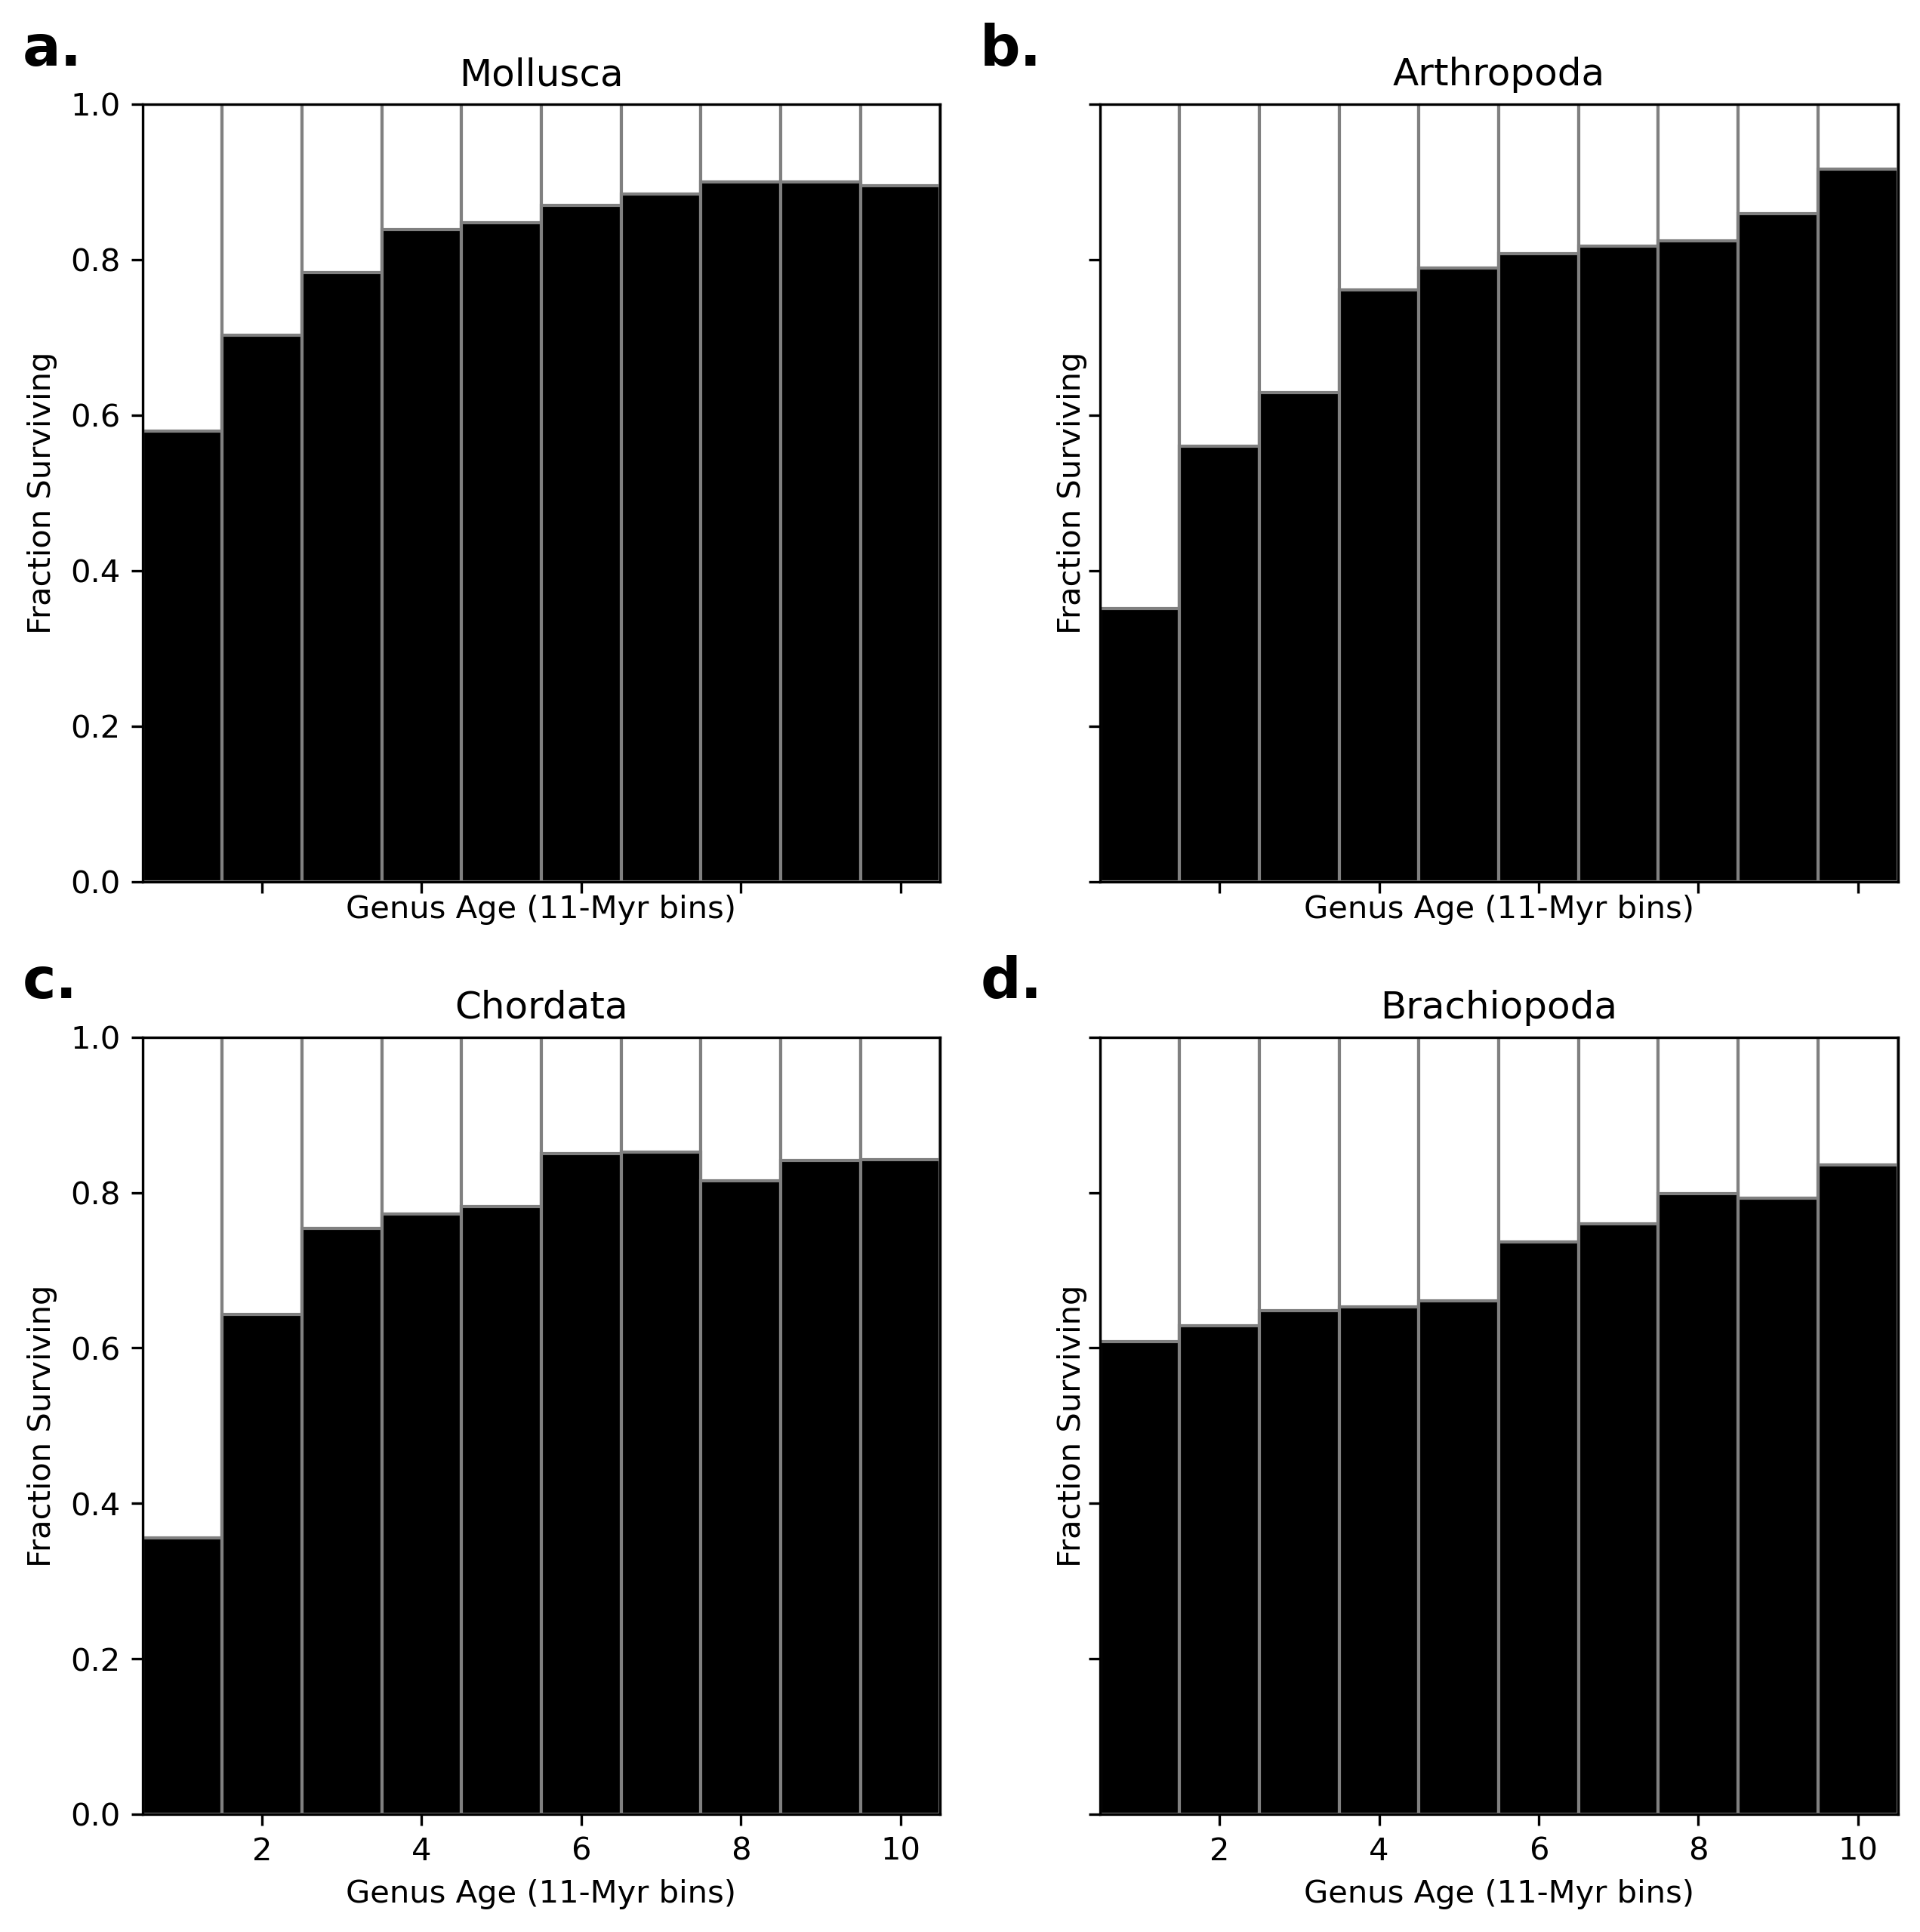

In [7]:
nested_clades = ["Mollusca","Arthropoda","Chordata","Brachiopoda"]
max_age = 10

if len(nested_clades) < 4:
    nested_clades += phyla_labels[-1-(4-len(nested_clades)):-1]
    nested_clades.reverse()
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(10, 10)
ax[0,0].set_ylim(0,1)
ax[0,0].set_xlim(0.5, max_age + 0.5)

for i in range(len(nested_clades)):
    ax[i//2,i%2].set_title(nested_clades[i])
    nestedCladeDict = getSubcladeOccurences(nested_clades[i], resolution=clade_resolution, 
                                            environment_only=env_type, plot=False)[clade_resolution]
    nestedCladeDurationMatrix = getDurationMatrix(nestedCladeDict, n_bins=50, t_0=550, max_duration=550, 
                                                  min_occurrences=1, min_unique=False)
    nestedCladeSurvDict, _ = getSurvivalsByAge(nestedCladeDurationMatrix, max_age=max_age)
    ax[i//2,i%2].bar(range(1, max_age + 1), [1]*max_age,color='white', edgecolor='gray', width=1)
    ax[i//2,i%2].bar(range(1, max_age + 1), list(nestedCladeSurvDict.values()), color='black', edgecolor='gray', width=1)
    ax[i//2,i%2].set_xlabel("%s Age (11-Myr bins)"%(clade_resolution.capitalize()))
    ax[i//2,i%2].set_ylabel("Fraction Surviving")
    ax[i//2,i%2].text(-1, 1.05, "%s."%(chr(97+i)), weight='bold', fontsize=18)

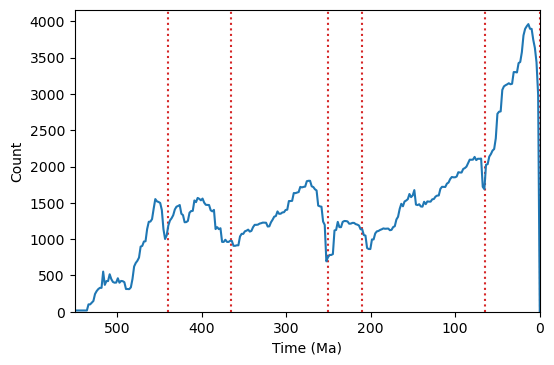

In [47]:
#subcladeDict2 = {x:occurrence_bootstrapper(subcladeDict[x]) for x in subcladeDict}

subcladeStartEnds = getSubcladeAgeRanges(subcladeDict, min_occurence_threshold=1)
#print(subcladeDictBrachFamilies)
plotSepkoski(subcladeStartEnds, event_lines=[440, 365, 250, 210, 65, 0], n_bins=1000)
plt.xlim(0, t_0)
plt.gca().invert_xaxis()

In [ ]:
plotStackedBarsWithDots(subcladeDict, min_occurence_threshold=1, colorcode=True, fig_dims=(10,10))

In [ ]:
plotStackedBarsWithDots(subcladeDict, min_occurence_threshold=mean_occurrences, colorcode=True, fig_dims=(10,10))#,text=True)

In [26]:
subcladesByNumOccurrences = sorted(subcladeDict.items(), key=lambda x:len(x[1]))
subcladesByNumOccurrences.reverse()

for i in range(min(20, len(subcladesByNumOccurrences))):
    print(subcladesByNumOccurrences[i][0], len(subcladesByNumOccurrences[i][1]))

Bivalvia 204422
Gastropoda 164272
Mammalia 120545
Rhynchonellata 112100
Cephalopoda 107185
Anthozoa 67232
Strophomenata 57704
Trilobita 51017
Insecta 50627
Conodonta 39506
Reptilia 34606
Ostracoda 28475
Stenolaemata 21390
Chondrichthyes 18484
Actinopteri 17965
Aves 15621
Crinoidea 13788
Saurischia 11478
Echinoidea 11031
Demospongiae 9132


In [27]:
subcladesByAge = sorted(subcladeDict.items(), key=lambda x:max(x[1])-min(x[1]))
subcladesByAge.reverse()

for i in range(min(20, len(subcladesByAge))):
    print(subcladesByAge[i][0], round(max(subcladesByAge[i][1])-min(subcladesByAge[i][1]), 2))

Ostracoda 587.99
Polychaeta 587.99
Demospongiae 587.99
Hexactinellida 579.53
Gastropoda 535.49
Tergomya 533.82
Bivalvia 526.99
Cephalopoda 526.99
Branchiopoda 526.93
Lingulata 526.93
Calcarea 526.6
Anthozoa 524.99
Xiphosura 523.91
Stenolaemata 522.93
Rhynchonellata 521.49
Hydrozoa 517.99
Polyplacophora 514.49
Craniata 514.49
Malacostraca 508.99
Crinoidea 508.93


In [39]:
extinctSubclades = {x:subcladeDict[x] for x in subcladeDict if min(subcladeDict[x]) > 50}
ratioExtinct = len(extinctSubclades) / len(subcladeDict)
print(round(100*ratioExtinct,2), "% extinct in modern.")
extinctSubclades = {x:extinctSubclades[x] for x in extinctSubclades if len(extinctSubclades[x]) > mean_occurrences}


61.19 % extinct in modern.


(550.0, 0.0)

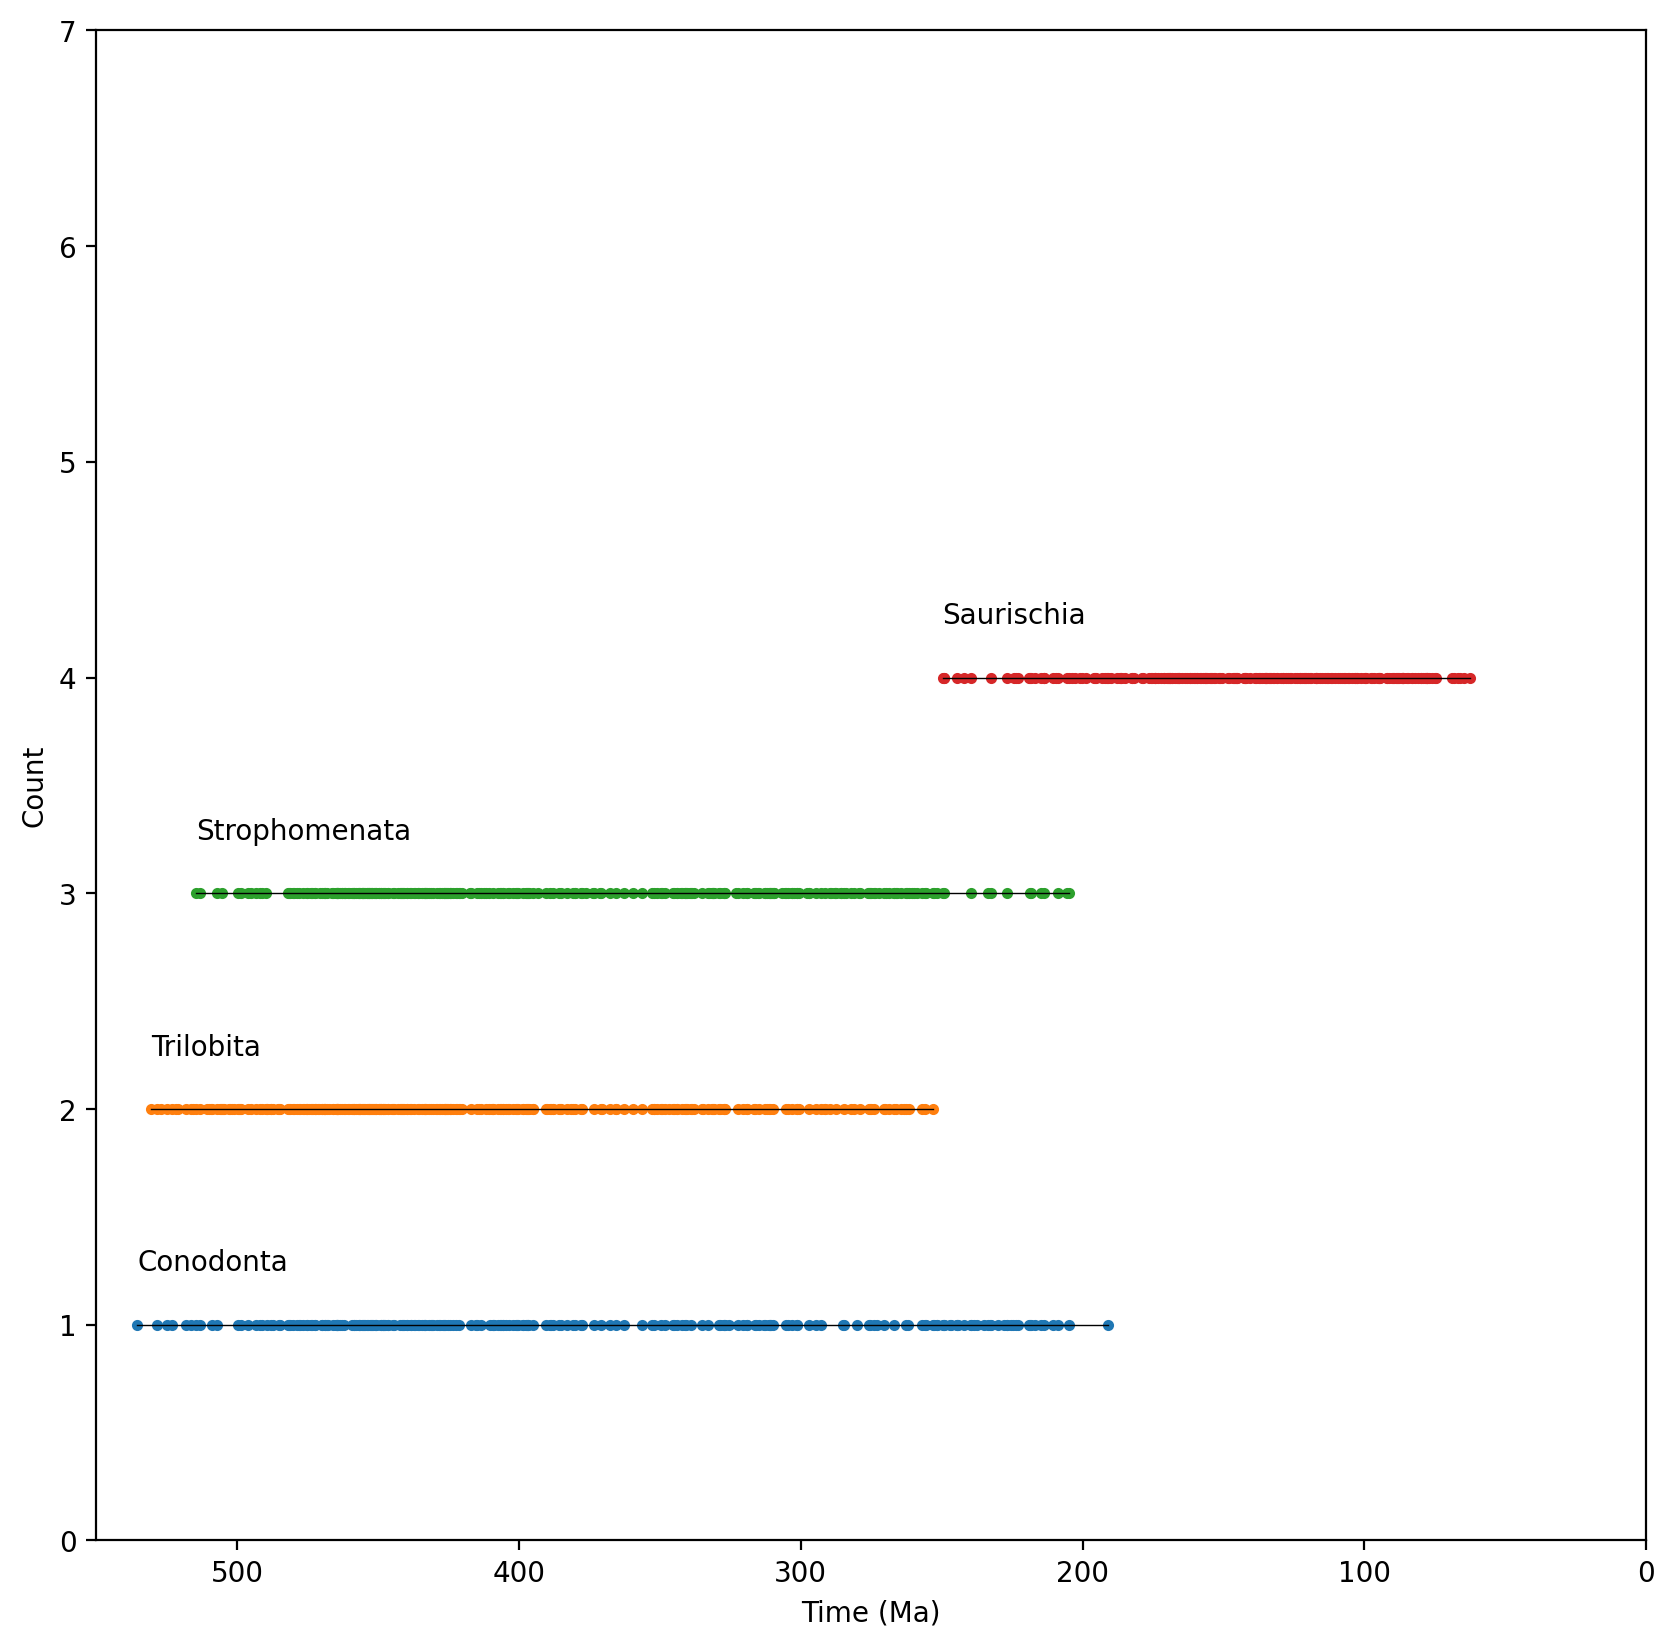

In [40]:
plotStackedBarsWithDots(extinctSubclades, min_occurence_threshold=mdn_occurrences, colorcode=False, fig_dims=(10,10), text=True)
plt.xlim(t_0,0)

In [41]:
extSubcladesByNumOccurrences = sorted(extinctSubclades.items(), key=lambda x:len(x[1]))
extSubcladesByNumOccurrences.reverse()
for i in range(min(20, len(extSubcladesByNumOccurrences))):
    print(extSubcladesByNumOccurrences[i][0], len(extSubcladesByNumOccurrences[i][1]), round(max(extSubcladesByNumOccurrences[i][1])-min(extSubcladesByNumOccurrences[i][1]), 2))

Strophomenata 57704 309.6
Trilobita 51017 277.33
Conodonta 39506 344.5
Saurischia 11478 187.34


In [42]:
extSubcladesByAge = sorted(extinctSubclades.items(), key=lambda x:max(x[1])-min(x[1]))
extSubcladesByAge.reverse()

for i in range(min(20, len(extSubcladesByAge))):
    print(extSubcladesByAge[i][0], round(max(extSubcladesByAge[i][1])-min(extSubcladesByAge[i][1]), 2), len(extSubcladesByAge[i][1]))

Conodonta 344.5 39506
Strophomenata 309.6 57704
Trilobita 277.33 51017
Saurischia 187.34 11478


40547 10069 22560


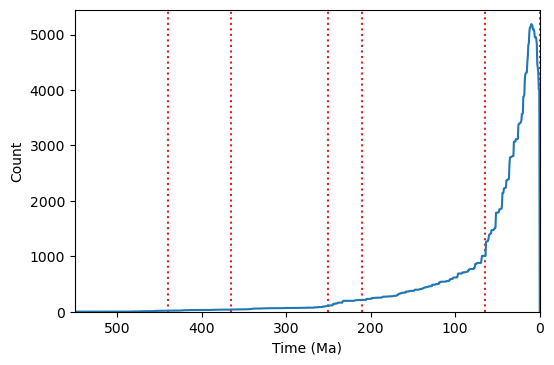

In [46]:
extinctSubclades = {x:subcladeDict[x] for x in subcladeDict if min(subcladeDict[x]) > 50}
ancientSubclades = {x:subcladeDict[x] for x in subcladeDict if min(subcladeDict[x]) > 200}
nonextinctSubclades = {x:subcladeDict[x] for x in subcladeDict if min(subcladeDict[x]) < 10}
print(len(extinctSubclades),len(nonextinctSubclades), len(ancientSubclades))

nonextinctSubcladeStartEnds = getSubcladeAgeRanges(nonextinctSubclades, min_occurence_threshold=1)
#print(subcladeDictBrachFamilies)
plotSepkoski(nonextinctSubcladeStartEnds, event_lines=[440, 365, 250, 210, 65, 0], n_bins=1000)
plt.xlim(0, t_0)
plt.gca().invert_xaxis()

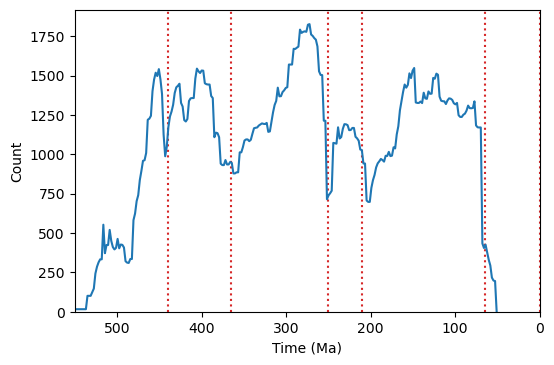

In [47]:
extinctSubcladeStartEnds = getSubcladeAgeRanges(extinctSubclades, min_occurence_threshold=1)
#print(subcladeDictBrachFamilies)
plotSepkoski(extinctSubcladeStartEnds, event_lines=[440, 365, 250, 210, 65, 0], n_bins=1000)
plt.xlim(0, t_0)
plt.gca().invert_xaxis()

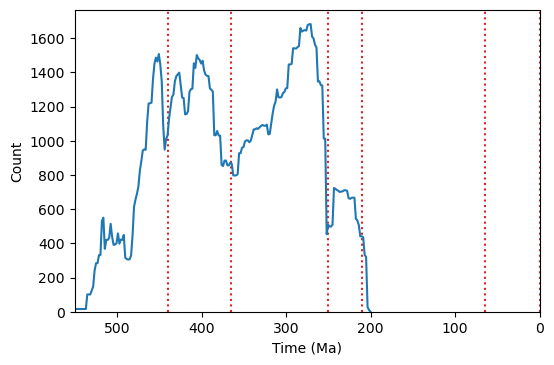

In [48]:
ancientSubcladeStartEnds = getSubcladeAgeRanges(ancientSubclades, min_occurence_threshold=1)
#print(subcladeDictBrachFamilies)
plotSepkoski(ancientSubcladeStartEnds, event_lines=[440, 365, 250, 210, 65, 0], n_bins=1000)
plt.xlim(0, t_0)
plt.gca().invert_xaxis()

In [ ]:
ancientInts = [abs(np.diff(ancientSubcladeStartEnds[x]))[0] for x in ancientSubcladeStartEnds]
nonextinctInts = [abs(np.diff(nonextinctSubcladeStartEnds[x]))[0] for x in nonextinctSubcladeStartEnds]
extinctInts = [abs(np.diff(extinctSubcladeStartEnds[x]))[0] for x in extinctSubcladeStartEnds]

plt.hist(ancientInts, label="extinct as of 200 Ma", color="black", alpha=0.3, bins=20)
plt.hist(nonextinctInts, label="present in modern", color="blue", alpha=0.3, bins=20)
plt.hist(extinctInts, label="extinct as of 50 Ma", color="red", alpha=0.3, bins=20)
plt.xlim(0,None)
plt.ylim(0,None)
plt.legend()
plt.xlabel("Duration (Ma)")
plt.ylabel("Class Count")
plt.vlines([np.mean(ancientInts)],0, len(subcladeStartEnds), color="black", alpha=0.3, linestyle=":")
plt.vlines([np.mean(extinctInts)],0, len(subcladeStartEnds), color="red", alpha=0.3, linestyle=":")
plt.vlines([np.mean(nonextinctInts)],0, len(subcladeStartEnds), color="blue", alpha=0.3, linestyle=":")

print(np.mean(ancientInts), np.mean(extinctInts), np.mean(nonextinctInts))